# 全ての誤分類タイプ平均してまとめるパターン

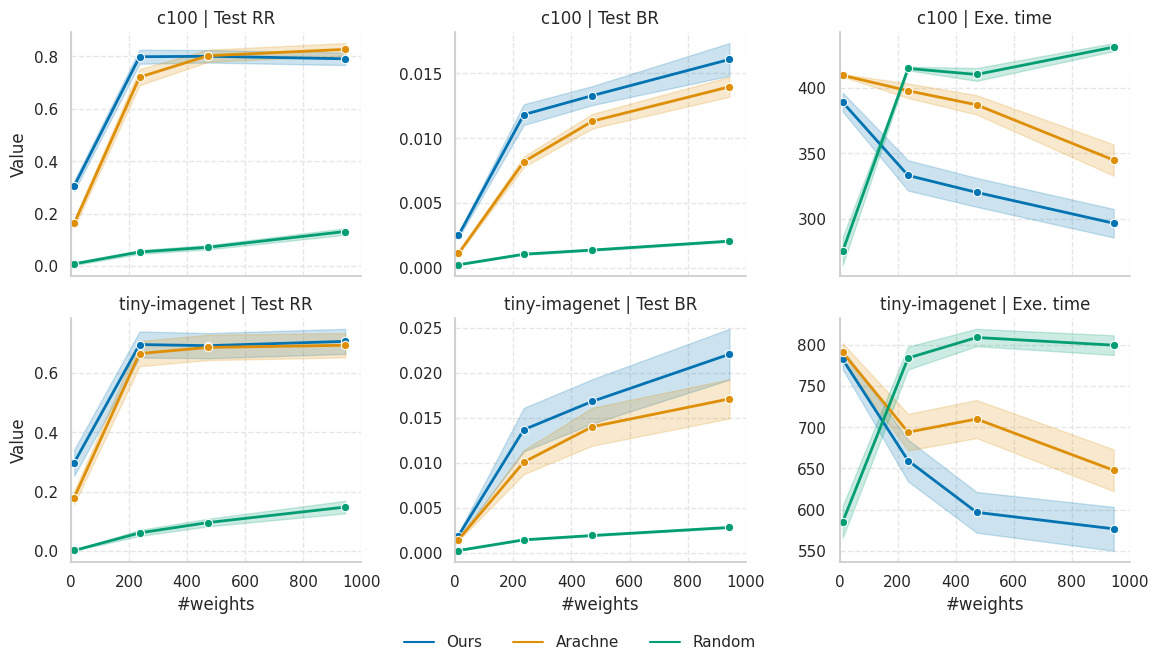

In [38]:
"""
Visualization script  (average over *all* fault-types, with ±1 SD band)
 ---------------------------------------------------------------------
* 横軸 : #Weights (11 / 236 / 472 / 944)   ─ 固定 x-lim 0–1000
* 縦軸 : Test RR, Test BR, Exe. time
* 行   : Dataset  –  c100, tiny-imagenet
* 列   : Metric
* 系列 : Repair method  –  Ours, Arachne, Random
* 塗り : 各ラインの ±1 SD を filled-area で表示
"""

import os, json, pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constant import ViTExperiment

# ─────────────── パラメータ ───────────────
ds_list          = ["c100", "tiny-imagenet"]
weight_nums      = [11, 236, 472, 944]
fl_method_list   = ["ours", "arachne", "random"]
tgt_rank_list    = [1, 2, 3]
misclf_type_list = ["src_tgt", "tgt"]
fpfn_list        = [None, "fp", "fn"]
num_reps         = 5
alpha            = 10 / 11
# ──────────────────────────────────────────

method_display = {"ours": "Ours", "arachne": "Arachne", "random": "Random"}
palette = sns.color_palette("colorblind", n_colors=len(method_display))

records = []                      # ← 個々の値をそのまま格納（平均しない）

for ds in ds_list:
    exp_obj        = getattr(ViTExperiment, ds.replace("-", "_"))
    pretrained_dir = exp_obj.OUTPUT_DIR.format(k=0)

    for w_num in weight_nums:

        # --- setting_id / id_prefix ヘルパ ---
        def make_setting_id(method):
            if w_num == 11:
                return f"alpha{alpha}_boundsArachne"
            return f"n{w_num}_alpha{alpha}_boundsArachne"

        def make_id_prefix(method):
            if method == "ours":
                return "4-1" if w_num != 11 else "3-2"
            if method == "arachne":
                return "4-1" if w_num != 11 else "3-1"
            if method == "random":
                return "4-1" if w_num != 11 else "3-2"
            raise ValueError(f"Unknown method: {method}")
        # --------------------------------------

        for fl_method in fl_method_list:
            setting_id = make_setting_id(fl_method)
            id_prefix  = make_id_prefix(fl_method)
            _fl_method = "bl" if fl_method == "arachne" else fl_method

            # ────────────────────────
            for tgt_rank, misclf_type, fpfn in product(tgt_rank_list,
                                                       misclf_type_list,
                                                       fpfn_list):
                # 無効組合せはスキップ
                if (misclf_type == "src_tgt" and fpfn is not None) or \
                   (misclf_type == "tgt"    and fpfn is None):
                    continue

                misclf_ptn = misclf_type if fpfn is None else f"{misclf_type}_{fpfn}"
                save_dir   = os.path.join(
                    pretrained_dir,
                    f"misclf_top{tgt_rank}",
                    f"{misclf_ptn}_repair_weight_by_de"
                )

                for reps_id in range(num_reps):
                    # ---------- TEST split (RR / BR) ----------
                    f_test = (
                        f"exp-repair-{id_prefix}-metrics_for_test_"
                        f"{setting_id}_{_fl_method}_reps{reps_id}.json"
                    )
                    p_test = os.path.join(save_dir, f_test)
                    if os.path.isfile(p_test):
                        with open(p_test) as f:
                            d = json.load(f)
                        records.append(dict(Dataset=ds, Weight=w_num,
                                            Method=fl_method, Metric="Test RR",
                                            Value=d["repair_rate_tgt"]))
                        records.append(dict(Dataset=ds, Weight=w_num,
                                            Method=fl_method, Metric="Test BR",
                                            Value=d["break_rate_overall"]))

                    # ---------- REPAIR split (time) ----------
                    f_rep = (
                        f"exp-repair-{id_prefix}-metrics_for_repair_"
                        f"{setting_id}_{_fl_method}_reps{reps_id}.json"
                    )
                    p_rep = os.path.join(save_dir, f_rep)
                    if os.path.isfile(p_rep):
                        with open(p_rep) as f:
                            d = json.load(f)
                        records.append(dict(Dataset=ds, Weight=w_num,
                                            Method=fl_method,
                                            Metric="Exe. time",
                                            Value=d["tot_time"]))
# ─────────────── DataFrame化 ───────────────
plot_df = pd.DataFrame(records)
plot_df["MethodLabel"] = plot_df["Method"].map(method_display)

# ──────────────── Plot ────────────────
sns.set(style="whitegrid", font="DejaVu Sans")
# 1) seaborn のスタイルで grid のデフォルトを変えておく
sns.set_style(
    "whitegrid",
    {
        "grid.linestyle": "--",   # 点線
        "grid.linewidth": 0.5,    # 細く
        "grid.color": ".9"       # 薄いグレー（0=黒, 1=白）
    }
)
g = sns.relplot(
    data       = plot_df,
    kind       = "line",
    x          = "Weight",
    y          = "Value",
    hue        = "MethodLabel",
    col        = "Metric",
    row        = "Dataset",
    marker     = "o",
    linewidth  = 2,
    palette    = palette,
    # errorbar  = ("ci", 90),    # ← ★ ここを変更
    errorbar  = ("se", 1),    # ← ★ ここを変更
    # errorbar  = "se",
    facet_kws  = dict(sharey=False),
    height     = 3.2,
    aspect     = 1.1
)
# ----- ① 既定凡例をいったん消す -----
g._legend.remove()

# ----- ② 軸からハンドル/ラベルを取得 -----
handles, labels = g.axes[0][0].get_legend_handles_labels()

# ----- ③ 図全体に横並びで凡例を再配置 -----
g.fig.legend(
    handles, labels,
    loc="lower center",        # 下中央
    bbox_to_anchor=(0.5, -0.05),  # (x, y)  y<0 で図の外
    ncol=len(method_display),  # 横並び
    frameon=False              # 枠線オフ（好みで）
)

# ----- ④ 下側に余白を作る -----
g.fig.subplots_adjust(bottom=0.18)   # 適宜 0.15〜0.25 で調整

g.set_xlabels("#weights")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(True, axis='y')
    ax.set_xlim(0, 1000)              # ← 横軸を 0–1000 に固定

plt.tight_layout()
plt.show()


# 誤分類タイプごとに描画するパターン

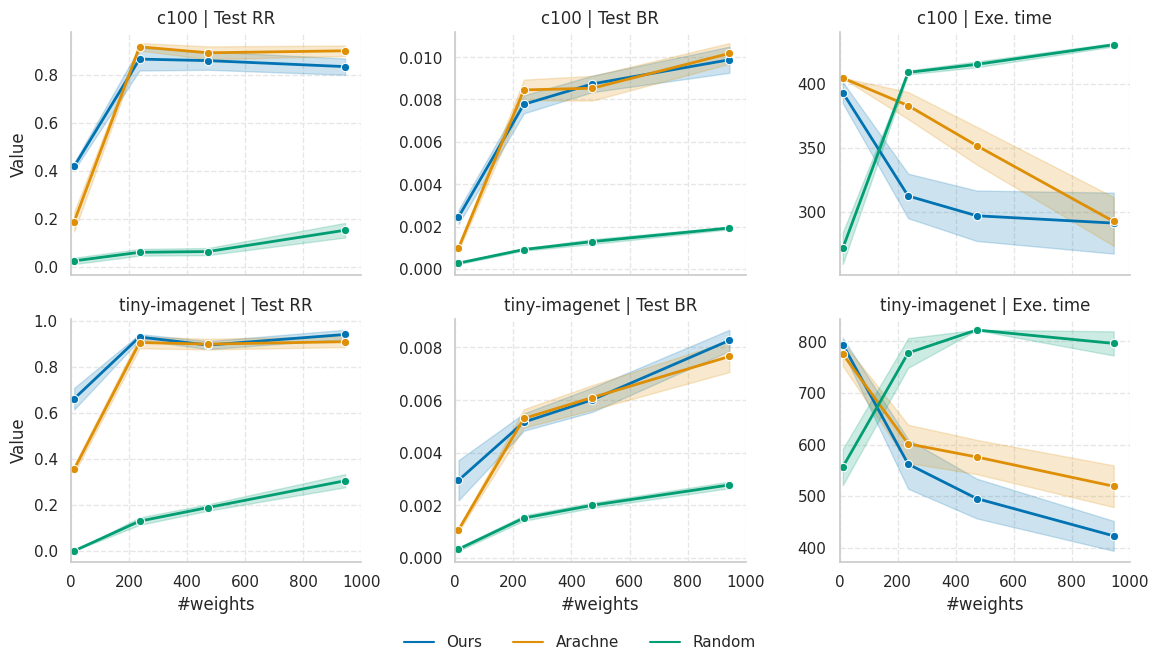

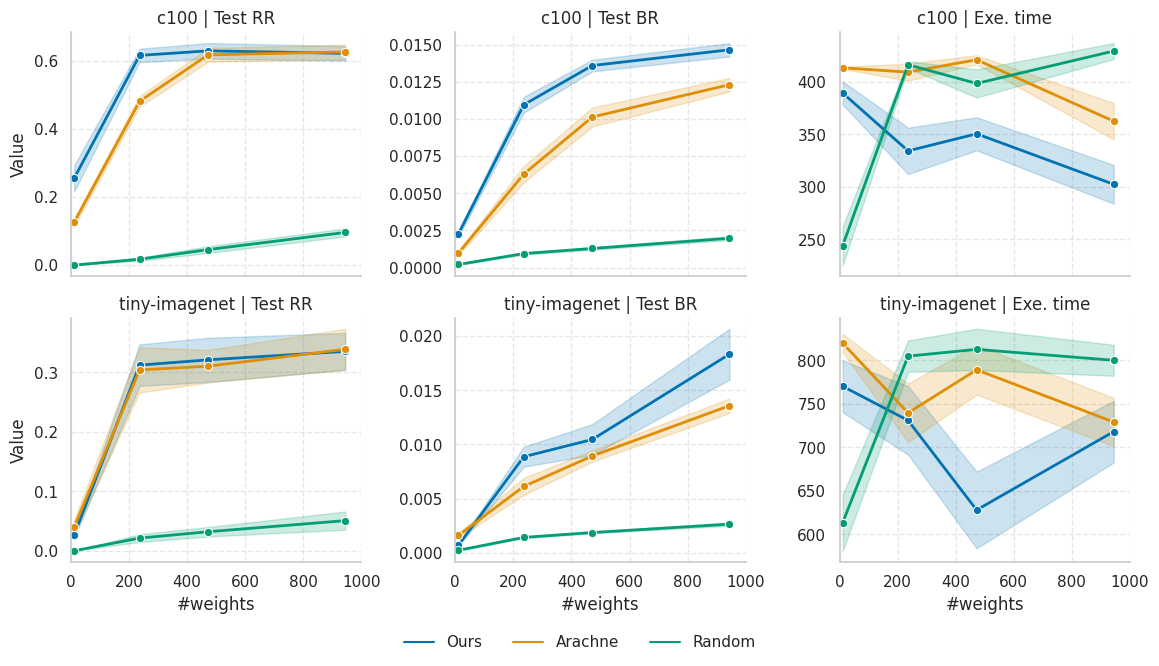

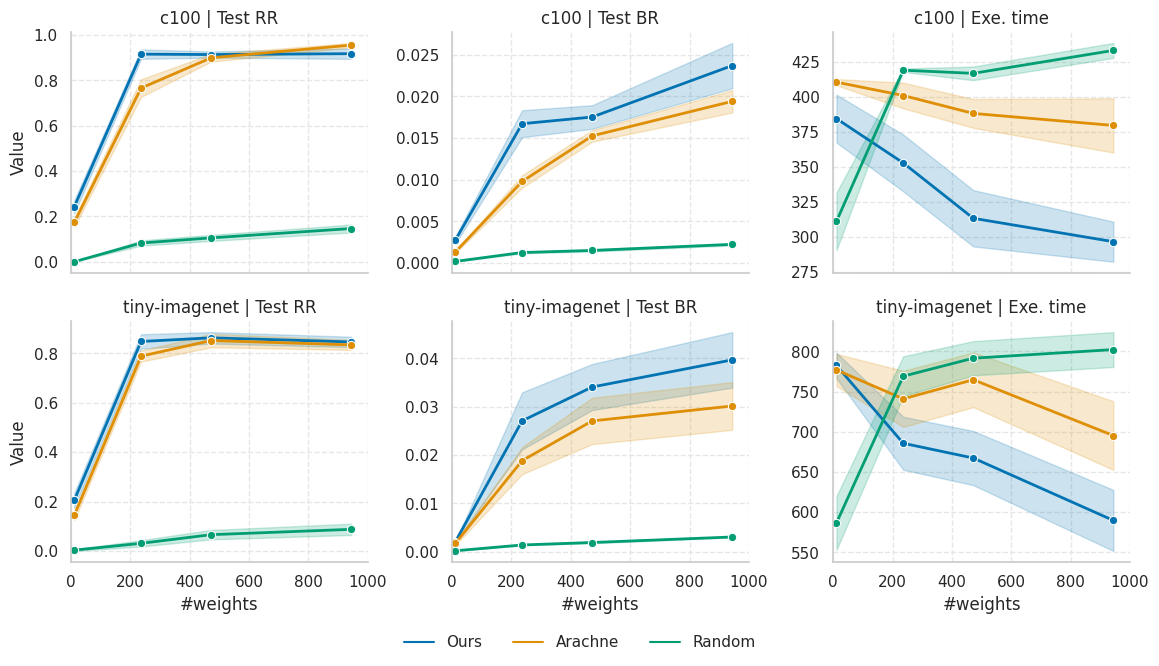

In [42]:
"""
Facet by fault-type 版
 ----------------------
* Fault-type ごとに 3 枚描画（src_tgt / tgt_fp / tgt_fn）
* 各図は Dataset×Metric＝2×3 面
* スタイル・凡例レイアウト・グリッド設定は
  「平均版」スクリプトと揃えています
"""

import os, json, pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constant import ViTExperiment

# ────────── 共通パラメータ ──────────
ds_list        = ["c100", "tiny-imagenet"]
weight_nums    = [11, 236, 472, 944]
fl_methods     = ["ours", "arachne", "random"]
tgt_rank_list  = [1, 2, 3]
num_reps       = 5
alpha          = 10 / 11

# fault-type → (misclf_type, fpfn) の組
misclf_groups = {
    "src_tgt": [("src_tgt", None)],
    "tgt_fp":  [("tgt", "fp")],
    "tgt_fn":  [("tgt", "fn")],
}
# ------------------------------------

method_display = {"ours": "Ours", "arachne": "Arachne", "random": "Random"}
palette = sns.color_palette("colorblind", n_colors=len(method_display))

# ---------- seaborn スタイル ----------
sns.set(style="whitegrid", font="DejaVu Sans")
# 1) seaborn のスタイルで grid のデフォルトを変えておく
sns.set_style(
    "whitegrid",
    {
        "grid.linestyle": "--",   # 点線
        "grid.linewidth": 0.5,    # 細く
        "grid.color": ".9"       # 薄いグレー（0=黒, 1=白）
    }
)
# ======================================

for ft_name, ft_keys in misclf_groups.items():
    records = []

    for ds in ds_list:
        exp_obj        = getattr(ViTExperiment, ds.replace("-", "_"))
        pretrained_dir = exp_obj.OUTPUT_DIR.format(k=0)

        for w_num in weight_nums:

            # setting_id と id_prefix を返すヘルパ
            def setting_id(method):
                return f"alpha{alpha}_boundsArachne" if w_num == 11 \
                       else f"n{w_num}_alpha{alpha}_boundsArachne"

            def id_prefix(method):
                if method == "ours":    return "4-1" if w_num != 11 else "3-2"
                if method == "arachne": return "4-1" if w_num != 11 else "3-1"
                if method == "random":  return "4-1" if w_num != 11 else "3-2"
                raise ValueError(method)

            for fl in fl_methods:
                sid  = setting_id(fl)
                pref = id_prefix(fl)
                _fl  = "bl" if fl == "arachne" else fl

                for tgt_rank in tgt_rank_list:
                    for mtype, fpfn in ft_keys:
                        mptn = mtype if fpfn is None else f"{mtype}_{fpfn}"
                        save_dir = os.path.join(
                            pretrained_dir,
                            f"misclf_top{tgt_rank}",
                            f"{mptn}_repair_weight_by_de"
                        )

                        for r in range(num_reps):
                            # ---- TEST ----
                            f_test = f"exp-repair-{pref}-metrics_for_test_{sid}_{_fl}_reps{r}.json"
                            p_test = os.path.join(save_dir, f_test)
                            if os.path.isfile(p_test):
                                d = json.load(open(p_test))
                                records += [
                                    dict(Dataset=ds, Weight=w_num, Method=fl,
                                         Metric="Test RR", Value=d["repair_rate_tgt"]),
                                    dict(Dataset=ds, Weight=w_num, Method=fl,
                                         Metric="Test BR", Value=d["break_rate_overall"])
                                ]
                            # ---- REPAIR ----
                            f_rep  = f"exp-repair-{pref}-metrics_for_repair_{sid}_{_fl}_reps{r}.json"
                            p_rep  = os.path.join(save_dir, f_rep)
                            if os.path.isfile(p_rep):
                                d = json.load(open(p_rep))
                                records.append(dict(Dataset=ds, Weight=w_num, Method=fl,
                                                     Metric="Exe. time", Value=d["tot_time"]))

    # ---------- DataFrame ----------
    df = pd.DataFrame(records)
    df["MethodLabel"] = df["Method"].map(method_display)

    # ---------- Plot ----------
    g = sns.relplot(
        data      = df,
        kind      = "line",
        x         = "Weight",
        y         = "Value",
        hue       = "MethodLabel",
        col       = "Metric",
        row       = "Dataset",
        marker    = "o",
        linewidth = 2,
        palette   = palette,
        errorbar  = ("se", 1),          # ±1 SE
        facet_kws = dict(sharey=False),
        height    = 3.2,
        aspect    = 1.1
    )

    # ── 凡例を横並びで下に ──
    g._legend.remove()
    handles, labels = g.axes[0][0].get_legend_handles_labels()
    g.fig.legend(handles, labels, loc="lower center",
                 bbox_to_anchor=(0.5, -0.05),
                 ncol=len(method_display), frameon=False)
    g.fig.subplots_adjust(bottom=0.18)

    # ── 軸ループ：グリッド / xlim / 黒枠 ──
    for ax in g.axes.flatten():
        ax.grid(True, axis='y')
        ax.set_xlim(0, 1000)

    g.set_xlabels("#weights")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    plt.tight_layout()
    plt.show()
